# Assignment 2: Function Approximation for Q Learning

Name: Chuqiao Song

ID: A53239614

### 1. Cartpole

A cartpole problem is shown below.
![pendulum2.png](pendulum2.png)

The equation for the cartpole problem is nonlinear in nature, but it has been shown through robust control theory that a linear version of the equation of the form $\dot{x} = Ax+Bu$ can be solved by a linear controller. Let us assume that we are interested in minimizing cart stray from the center, and pendulum falling. It turns out that typical techniques - open loop control, PID control, root locus, etc. is not suitable for stabilizing both the cart position (keep near center) or the pole angle (keep vertical). The solution to this question is a linear quadratic controller, but we won't be using the solution at the moment.

### Setup Environment for Function Approximation


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Create the CartPole game environment
env = gym.make('CartPole-v0')
env.reset()
use_cuda = torch.cuda.is_available()
# use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


#### Demonstrate your understanding of the simulation
For OpenAI's CartPole-v0 environment,
- describe the reward system
- describe the each state variable (observation space)
- describe the action space

Ans:

Describe the reward system
- Reward is 1 for every step taken, including the termination step

Describe the each state variable (observation space):
- The observation space are four dimensions space.
- obersvation[0] is the cart position 
- obersvation[1] is the cart velocity 
- obersvation[2] is the pole angle
- obersvation[3] is the pole velocity at tip

Describe the action space:
- There are two actions which are 0 and 1. The 0 means push cart to left, and 1 means push cart to right.


### Write a Deep Neural Network class that creates a dense network of a desired architecture
In this problem we will create neural network that is our function that takes states to q-values: $q=f(x)$. While any function approximator could be used (i.e. Chebyshev functions, taylor series polynomials), neural networks offer a most general form of 1st-order smooth function (though comprising of trivial small activation functions means that complex functions require a significant amount of weights to identify). 

Create a class for a QNetwork that uses PyTorch to create a fully connected sequential neural network, of the following properties:
- solver: Adam

- input and hidden layer activation function: tanh

- output activation function: linear

- loss: MSE

- learning_rate: 0.01

- decay_rate:  5/num_episodes (epsilon)

- hidden_state sizes: 64 (one layer)

- state and action sizes: 4 states, 2 actions


In [2]:
class Net(nn.Module):
# Define your network here
    def __init__(self, state_size, action_size, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(hidden_size, action_size)
        self.out.weight.data.normal_(0, 0.1)   # initialization
    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        Qs_actions = self.out(x) # Q value for one state, at different actions
        return Qs_actions

class QNetwork:
    def __init__(self, learning_rate, state_size, action_size, hidden_size, alpha_decay):
        self.LR = learning_rate
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.alpha_decay = alpha_decay
        self.model = Net(self.state_size, self.action_size, self.hidden_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LR)
        self.criterion = nn.MSELoss()
    
    def learn(self, batch_Q_behavior, batch_Q_target):
        loss = self.criterion(batch_Q_behavior, batch_Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#### Write a Replay class that includes all the functionality of a replay buffer
The replay buffer should kept to some maximum size (10000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). The replay buffer should also be able to generate a minibatch. The generate_minibatch method should take in DQN, targetDQN, selected batch_size, and return the states present in the minibatch and the target Q values for those states.

In [3]:
class Replay():
    def __init__(self, max_size):
        self.capacity = max_size
        self.memory = []
        self.position = 0
        self.gamma = 0.99

    def initialize(self, init_length, envir):
        st = env.reset()
        for _ in range(init_length):
            a = random.randint(0, 1)
            st1, r, done, info = env.step(a)
            self.push((st, a, st1, r, done))
            if done: st = env.reset()
            else : st = st1
            
    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity
        
    def generate_minibatch(self, DQN, targetDQN, batch_size):
        batch_memory = random.sample(self.memory, batch_size) #return a list
        batch_memory = list(zip(*batch_memory))
        
        batch_st = Variable(FloatTensor(batch_memory[0]))
        batch_a = Variable(torch.unsqueeze(LongTensor(batch_memory[1]),1))
        batch_st1 = Variable(FloatTensor(batch_memory[2]))
        batch_r = Variable(torch.unsqueeze(FloatTensor(batch_memory[3]),1))
        
        batch_done = FloatTensor(batch_memory[4])  ## Tensor (128,)
        batch_Q_behavior = DQN.model(batch_st).gather(1, batch_a)
        mask = 1 - batch_done   # if done is true, change the target to just reward
        batch_Q_next = targetDQN.model(batch_st1).detach() #(128,1), when doing max it is (128,)
        QQ_next = Variable((batch_Q_next.max(1)[0].data * mask).view(batch_size, 1))
        batch_Q_target = batch_r + self.gamma*(QQ_next)
        return batch_Q_behavior, batch_Q_target
         
    def __len__(self):            
        return len(self.memory)


Write a function that creates a minibatch from a buffer

### Perform Function Approximation
Initialize DQN networks and Replay objects

In [4]:
# Initialize DQN
# Play around with your learning rate, alpha decay and hidden layer units 
# Two layers with a small number of units should be enough
learning_rate = 0.01 
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
hidden_size = 64
alpha_decay = 0.1
batch_size = 500

DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
# set targetDQN weights to DQN weights
# for ex. targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)
targetDQN.model.load_state_dict(DQN.model.state_dict())
replay = Replay(max_size=10000) ## Initialize Replay Buffer
replay.initialize(init_length=1000, envir=env) ## Populate the initial experience buffer

if use_cuda:
    print('run gpu !')
    targetDQN.model.cuda()
    DQN.model.cuda()
else: 
    print('gpu not activited !')

run gpu !


#### Create a function that solves the above environment using a deep Q network that uses a minibatch strategy.
Use the following parameters (these had to be derived empirically - there is generally no trusted way of choosing the right parameter values - i.e. gamma, number of episodes, decay rate, min_epsilon). 

Generate a graph of the average return per episode every 100 episodes.

In [5]:
# Runtime parameters
num_episodes = 2000            # max number of episodes to learn from
gamma = 0.99                   # future reward discount
max_steps = 500                # cut off simulation after this many steps
# Exploration parameters
min_epsilon = 0.01             # minimum exploration probability
decay_rate = 5/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)

for ep in range(1, num_episodes):
    print(ep, returns[ep-1], end = '\r')
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    # --> start episode
    total_reward = 0
    state = env.reset()
    
    for step in range(max_steps):
        # generate the steps in each episode 
        # explore/exploit and get action using DQN
        if random.random()<= epsilon:
            action = random.randint(0,1)
        else:
            var_state = Variable(torch.unsqueeze(FloatTensor(state),0)) # here change the (4,) to (1,4) in variable 
            Qs_actions = DQN.model.forward(var_state) # shape of (1, 2) variable
            cuda_tensor_action = torch.max(Qs_actions,1)[1].data
            action = int(cuda_tensor_action.cpu().numpy())
           
        new_state, reward, done, _ = env.step(action)
        total_reward += reward
        replay.push((state, action, new_state, reward, done))
        
    # perform action and record new_state, action, reward
    # populate Replay experience buffer 
        if done:  break
        else: state = new_state 
    # <-- end episode
    returns[ep] = total_reward
    
    batch_Q_behavior, batch_Q_target = replay.generate_minibatch(DQN, targetDQN, batch_size) #outputs and targets
    DQN.learn(batch_Q_behavior, batch_Q_target) 
    targetDQN.model.load_state_dict(DQN.model.state_dict())
print('finished training')



finished training


# Post Processing

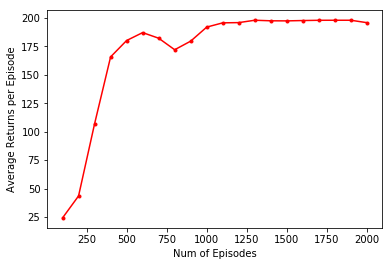

In [6]:
# plot average returns
returns_over_100_episodes = []
x = []
for i in range(0,int(num_episodes/100)):
    returns_over_100_episodes.append(sum(returns[100*i:100*(i+1)-1])/100)
    x.append((i+1)*100)
plt.plot(x,returns_over_100_episodes,'.-r')
plt.ylabel('Average Returns per Episode')
plt.xlabel('Num of Episodes')
plt.show()
    

In [9]:
# DEMO FINAL NETWORK
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())
state = np.reshape(state, [1, state.size])
total_reward = 0
for i in range(0, max_steps):
    #env.render() # here I comment the render for pyplot package issue
    # Get action from Q-network
    var_state = Variable(torch.unsqueeze(FloatTensor(state[0]),0))
    # above change the (4,) to (1,4) in variable 
    
    # Qs = output of DQN.model when state is passed in
    Qs = DQN.model.forward(var_state)# shape of (1, 2) variable
    action = int(torch.max(Qs,1)[1].data.cpu().numpy())
    # torch.max(Qs,1) get max value and its index of Qs along 1 axis, and torch.max(Qs,1)[1] is to get maxindex
    # Take action, get new state and reward
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    
    if done: break
    else: state = np.reshape(next_state, [1, state.size])
print(i)


198


In [ ]:
# save the model
np.save("./outputs/returns.npy", returns)
# myreturns = np.load( "./outputs/returns.npy" )
torch.save(DQN.model, './outputs/trainedDQN.pkl')
# myDQN = torch.load('./outputs/trainedDQN.pkl')

In [ ]:
############################Some Untils###################

##### save the array of the returns
# np.save("returns.npy", returns)
# myreturns = np.load( "returns.npy" )

##### save the whole model
# torch.save(DQN.model, './outputs/trainedDQN.pkl')
# myDQN = torch.load('./outputs/trainedDQN.pkl')

##### save the parameter of the model
# torch.save(DQN.model.state_dict(), './outputs/DQN_params.pkl')
# need construct a new network
# myDQN.load_state_dict(torch.load('./outputs/DQN_params.pkl'))

##### load the whole model
# myDQN = torch.load('./outputs/DQN.pkl', map_location=lambda storage, loc: storage)
# myDQN.cpu()



###### running the epochs 
# for epoch in range(num_epochs):
#     train(...)  # Train
#     acc = eval(...)  # Evaluate after every epoch

#     # Some stuff with acc(accuracy)
#     ...

#     # Get bool not ByteTensor
#     is_best = bool(acc.numpy() > best_accuracy.numpy())
#     # Get greater Tensor to keep track best acc
#     best_accuracy = torch.FloatTensor(max(acc.numpy(), best_accuracy.numpy()))
#     # Save checkpoint if is a new best
#     save_checkpoint({
#         'epoch': start_epoch + epoch + 1,
#         'state_dict': model.state_dict(),
#         'best_accuracy': best_accuracy
#     }, is_best)


####### def the checkpoint
# def save_checkpoint(state, is_best, filename='/output/checkpoint.pth.tar'):
#     """Save checkpoint if a new best is achieved"""
#     if is_best:
#         print ("=> Saving a new best")
#         torch.save(state, filename)  # save checkpoint
#     else:
#         print ("=> Validation Accuracy did not improve")



######## resume the saved state
# if cuda:
#     checkpoint = torch.load(resume_weights)
# else:
#     # Load GPU model on CPU
#     checkpoint = torch.load(resume_weights,
#                             map_location=lambda storage,
#                             loc: storage)
# start_epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']
# model.load_state_dict(checkpoint['state_dict'])
# print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))
